In [19]:
import rioxarray
import pystac

import torch
import torchdata
import zen3geo
import os
import numpy as np
import xarray as xr
import math

In [2]:
def quick_viz(zengeodatapipe):
    it = iter(zengeodatapipe)
    ds_a = next(it)
    return ds_a
    
def calc_ndvi(bandstack:xr.DataArray,red_id=1, nir_id=3):
    """
    Combine a xarray.DataArray (MS BANDS) inputs into an xarray.Dataset with 
    data variables named bands, appending the band ndvi.
    Assuming band 1 is RED, band 2 is NIR
    """

    # Create NDVI index, band numbers can be adjusted
    ds_b = bandstack.astype(float)
    red: xr.DataArray = ds_b.sel(band=red_id)
    nir: xr.DataArray = ds_b.sel(band=nir_id)
    
    ndvi = (nir-red)/(nir+red)
    ndvi.name = "ndvi"
    ndvi = rescale_floats(ndvi)
    return ndvi
    
def calc_bi(bandstack:xr.DataArray,red_id=1,green_id=2,blue_id=3):
    """
    Combine a xarray.DataArray (MS BANDS) inputs into an xarray.Dataset with 
    data variables named bands, resulting in bi.
    Assuming band 1 is RED, band 2 is green, and blue is 3
    """
    
    # Create datacube with VH and VV channels from SAR + Copernicus DEM mosaic
    ds_b = bandstack.astype(float)
    red: xr.DataArray = ds_b.sel(band=red_id)
    green: xr.DataArray = ds_b.sel(band=green_id)
    blue: xr.DataArray = ds_b.sel(band=blue_id)
    bi = math.sqrt((red**2 + green**2 + blue**2)/3)
    bi.name = "bi"
    bi = rescale_floats(bi)
    return bi
    
def calc_sci(bandstack:xr.DataArray,red_id=1,green_id=2):
    """
    Combine a xarray.DataArray (MS BANDS) inputs into an xarray.Dataset with 
    data variables named bands, resulting in sci.
    Assuming band 1 is RED, band 2 is green
    """
    
    # Create datacube with VH and VV channels from SAR + Copernicus DEM mosaic
    ds_b = bandstack.astype(float)
    red: xr.DataArray = ds_b.sel(band=red_id)
    green: xr.DataArray = ds_b.sel(band=green_id)
    sci = (red-green)/(red+green)
    sci.name = "sci"
    sci = rescale_floats(sci)
    return sci
    
def calc_gli(bandstack:xr.DataArray,red_id=1,green_id=2,blue_id=3):
    """
    Combine a xarray.DataArray (MS BANDS) inputs into an xarray.Dataset with 
    data variables named bands, resulting in gli.
    Assuming band 1 is RED, band 2 is green, and blue is 3
    """
    
    # Create datacube with VH and VV channels from SAR + Copernicus DEM mosaic
    ds_b = bandstack.astype(float)
    red: xr.DataArray = ds_b.sel(band=red_id)
    green: xr.DataArray = ds_b.sel(band=green_id)
    blue: xr.DataArray = ds_b.sel(band=blue_id)
    gli = (2*(green-red-blue)/(2*green+red+blue))
    gli.name = "gli"
    gli = rescale_floats(gli)
    return gli
    
        
    

def merge_with_index(original, index):
    return xr.merge(objects = [original, index], join ="override")
    
def collate_index(list_of_collates:tuple) -> xr.Dataset:
    index, all= list_of_collates
    dataset = xr.merge(objects = [index, all], join="override")
    return dataset
    
def rescale_floats(arr) -> xr.DataArray:
    return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8',casting = "unsafe")

In [3]:
# for example take an orthomosaic image in the folder data:
folder_to_search = "data"
files = [os.path.join(folder_to_search, item) for item in os.listdir(folder_to_search)]
ortho = rioxarray.open_rasterio(files[0], default_name = "ortho")


In [4]:
ndvi = calc_ndvi(ortho)


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [5]:
all = merge_with_index(ortho, ndvi)

In [6]:
dp = torchdata.datapipes.iter.IterableWrapper([all])

In [7]:
dp_xbatcher = dp.slice_with_xbatcher(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})

In [8]:
ds_a = quick_viz(dp_xbatcher)

In [15]:
chips = [chip for chip in dp_xbatcher]
print(f"Number of chips: {len(chips)}")
sample = chips[600]

Number of chips: 2508


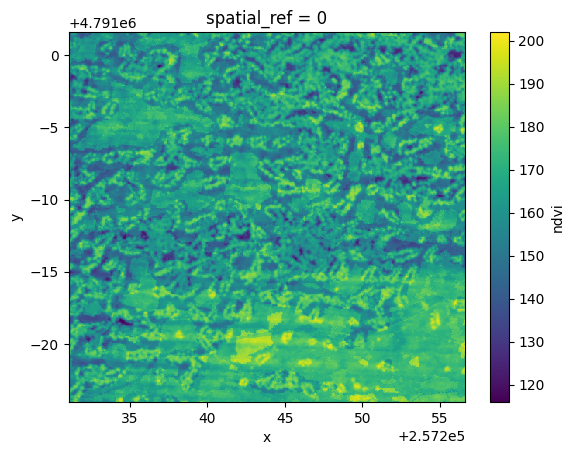

In [18]:
sample.ndvi.plot.imshow()